The scaling of computation in the last decade has allowed to reproduce the behavior and structure of the brain, leading to breakthrought in both machine learning through training artificial neural networks and in neuroscience through simulation. 

Still the complexity of artificial and biological networks remains a mystery, in particular most contemporary models have manually defined connectivity.

However the dynamic generation and deletion of connexion among neurons is crucial to break important mechanisms associated with learning.

In [1]:
import numpy as np
from scipy import sparse

from matplotlib import pyplot as plt
from seaborn import heatmap, color_palette

# Utility functions
from reservoir.utility import show_matrice, show_ei_matrix

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Reservoir functions

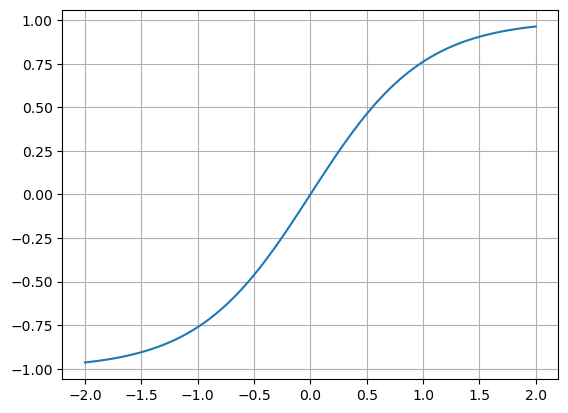

In [2]:
from importlib import reload
import reservoir.reservoir

from reservoir.reservoir import update_ei_reservoir, ridge_regression, train, run
from reservoir.reservoir import synaptic_scaling, activation_target_definition, constant_synaptic_scaling
from reservoir.activation_functions import tanh, heaviside, sigmoid

reload(reservoir.reservoir)

# SEED
SEED = 3789

# the activation function choosen for the rest of the experiment
# activation_function = lambda x : sigmoid(2*(x-0.5))
activation_function = lambda x : tanh(x)

plt.plot(np.linspace(-2, 2, 100), activation_function(np.linspace(-2, 2, 100)))
plt.grid()

In [3]:
from scipy.stats import poisson

mu = 100
timesteps = 100000
n_e=100

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs1 = (U - U.min()) / (U.max() - U.min())

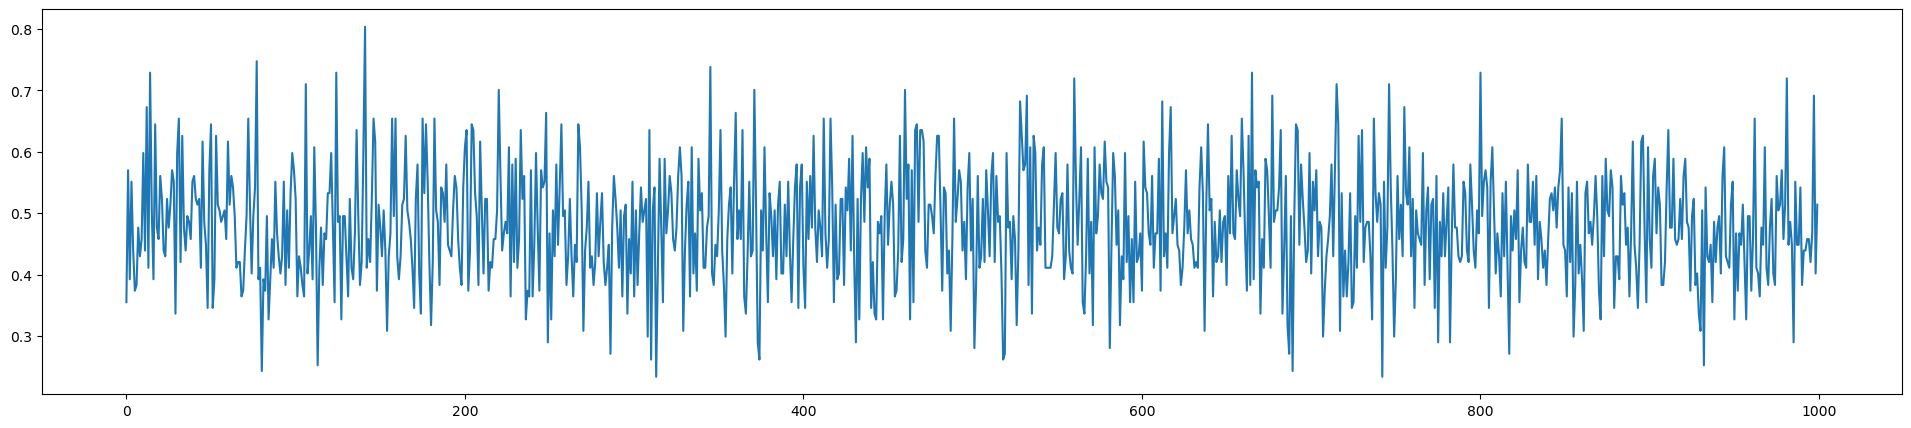

In [4]:
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs1[4,36000:37000])
plt.show()

In [5]:
from scipy import signal

# Apply a low-pass filter on with scipy.signal.filtfilt
def low_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='low', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def high_pass_filter(data, cutoff, fs, order=5):
    b, a = signal.butter(order, cutoff, btype='high', analog=False, fs=fs)
    return signal.filtfilt(b, a, data)

def band_pass_filter(data, lowcut, highcut, fs, order=5):
    b, a = signal.butter(3, [lowcut, highcut], btype='band', fs=fs)
    return signal.filtfilt(b, a, data)


# Algorithm
https://www.nature.com/articles/s41598-018-22077-3#Fig1

$ \Delta z_i =  \frac {1}{\beta}(target\_r - r_i) $

In [6]:
# helper function
def count_incoming_connexions(W):
    incoming_connexion = W.nonzero()[0]
    incoming_connexion_count = np.zeros(W.shape[0])
    for i in incoming_connexion:
        incoming_connexion_count[i] +=1
    return incoming_connexion_count

## Matrice initialization

https://www.nature.com/articles/s41598-018-22077-3
Based initialy on : 

    https://www.nature.com/articles/s41598-018-22077-3/tables/1
    N = 125 (12500 in the paper)
    Ratio of ne% = 0.8 -> ne = 100; ni% = 0.2  -> ni=25
    
    W_ei : Incoming excitatory connections per inhibitory neuron :10, with synaptic weight = 0.1mV
    W_ie : Incoming inhibitory connections per neuron :2,5, with synamtic weight : -0.8mV

In [9]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity =  0.3
connectivity_e = 0 # from the article
connectivity = 0.1 # from the article

# HYPERPARAMETERS
INCREMENT = 100
VALUE = 0.05
bias_scaling = 0.1
input_scaling = 1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity_e, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, 1, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, 1, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, 1, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

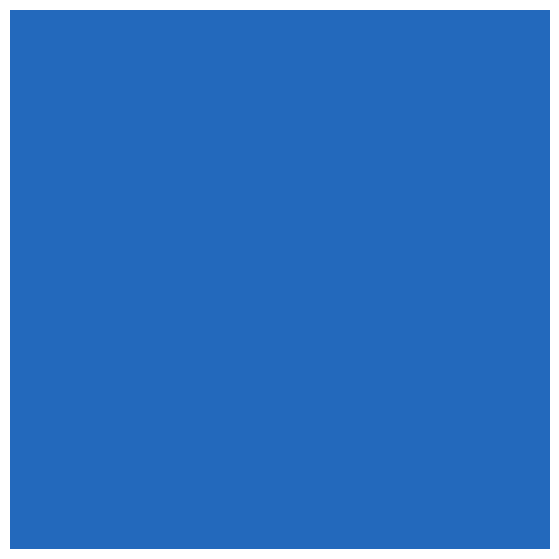

In [10]:
show_ei_matrix(W_ee, W_ei, W_ie)

## Parameters grid exploration

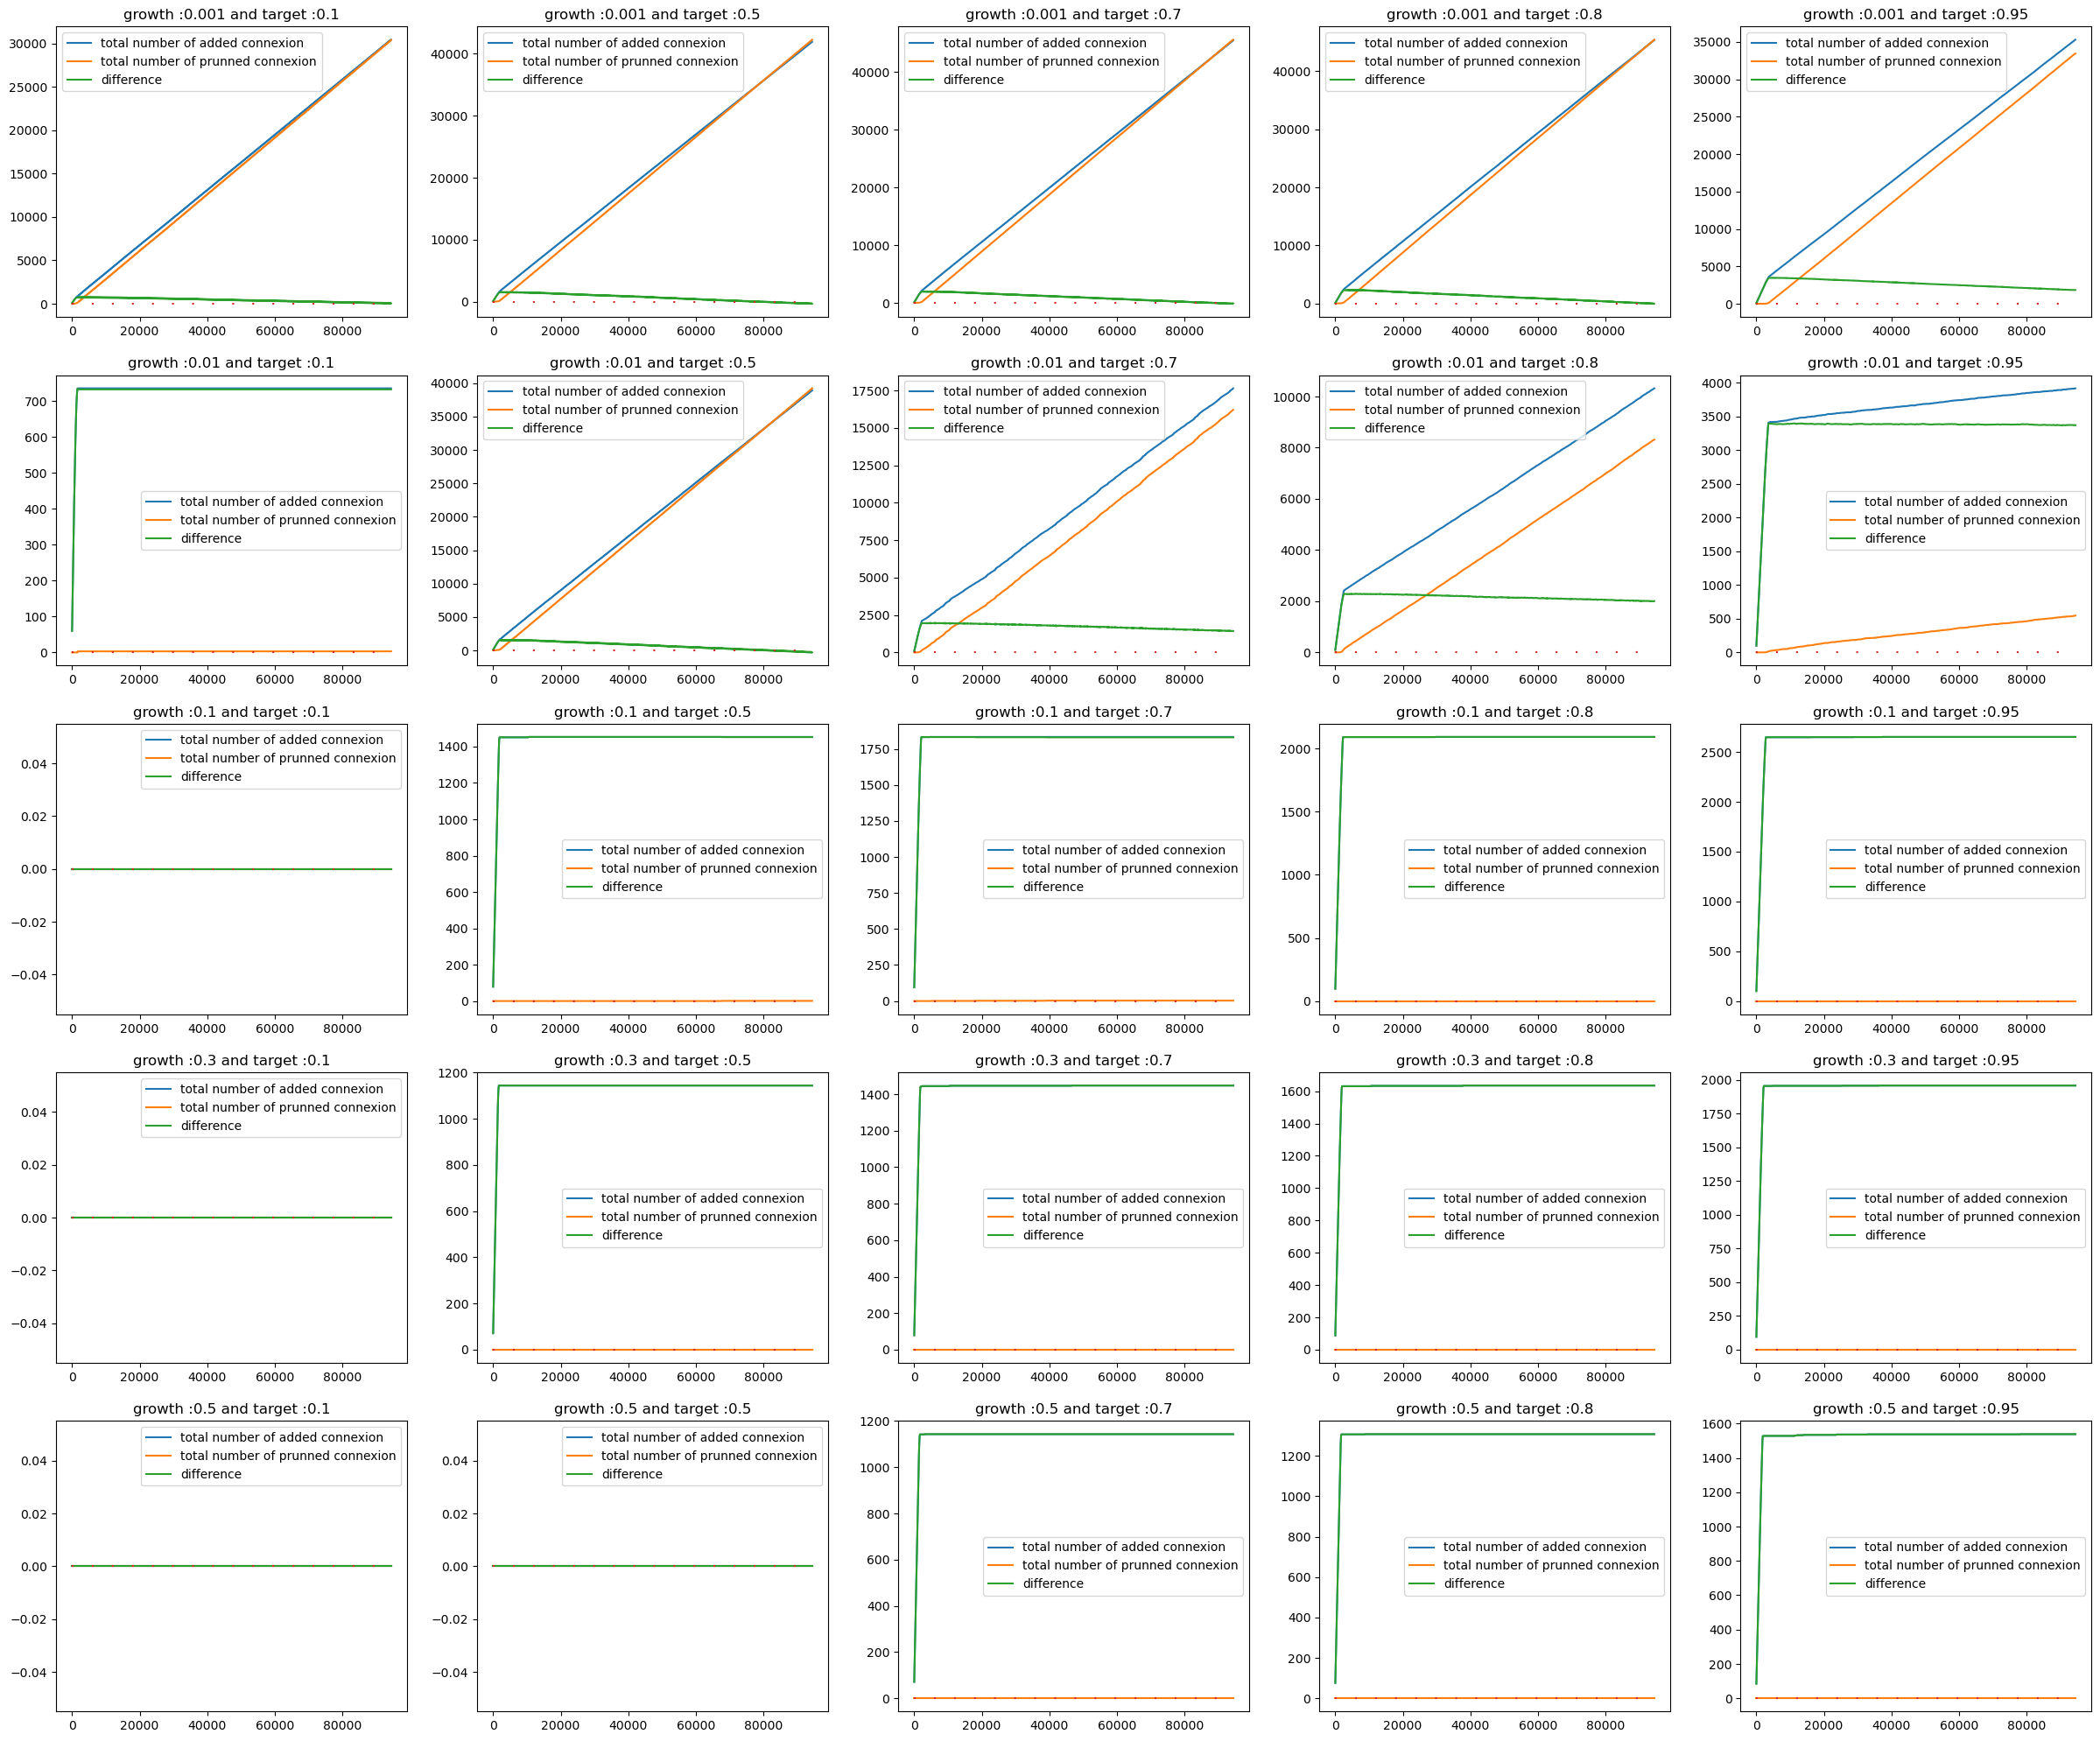

In [11]:
%matplotlib inline
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

GROWTH_PARAMETER_ARRAY = [0.001, 0.01, 0.1, 0.3, 0.5]
TARGET_RATE_ARRAY = [0.1, 0.5, 0.7, 0.8, 0.95]
# The parameters you want to see the influence
fig, ax = plt.subplots(len(GROWTH_PARAMETER_ARRAY), len(TARGET_RATE_ARRAY), figsize=(30, 25))
k = 0
for growth_parameter in GROWTH_PARAMETER_ARRAY:
    j = 0
    for target_rate in TARGET_RATE_ARRAY:
        # Initialisation
        W_ee_adsp = W_ee.copy()
        W_ie_adsp = W_ie.copy()
        W_ei_adsp = W_ei.copy()
        u_train_adsp1 = inputs1.copy()
        state_e = last_state_e
        state_i = last_state_i
        Win_e_adsp = Win_e

        step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []
        mean_prun = []

        incoming_connexion_count_history = []
        state_history_e = []
        state_history_i = []

        for i in range(INCREMENT * 5):
            state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train_adsp1[:,i], state_e, state_i, leaky_rate, bias_e,
                                                       bias_i, activation_function)
            state_history_e.append(state_e)
            state_history_i.append(state_i)
        u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
        train_length = len(u_train_adsp1[1, :])

        while train_length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

            # For excitatory neurons (We and Wie)
            delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE)

            # For inhibitory neurons (Wi)
            # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

            for i in range(INCREMENT):
                state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train_adsp1[:,i], state_e, state_i, leaky_rate, 
                                                       bias_e, bias_i, activation_function)
                state_history_e.append(state_e)
                state_history_i.append(state_i)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
            train_length = len(u_train_adsp1[1, :])

            total_add += nb_new_add_e  # + nb_new_add_i
            total_prun += nb_new_prun_e # + nb_new_prun_i
            add.append(total_add)
            prun.append(total_prun)

            step += 1
        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step) * INCREMENT, add, label="total number of added connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, prun, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, add - prun, label="difference")
        ax[k][j].plot(np.arange(step) * INCREMENT, [0] * step, linestyle=(0, (1, 10)))
        ax[k][j].title.set_text(f'growth :{growth_parameter} and target :{target_rate}')
        ax[k][j].legend()
        j += 1
    k += 1


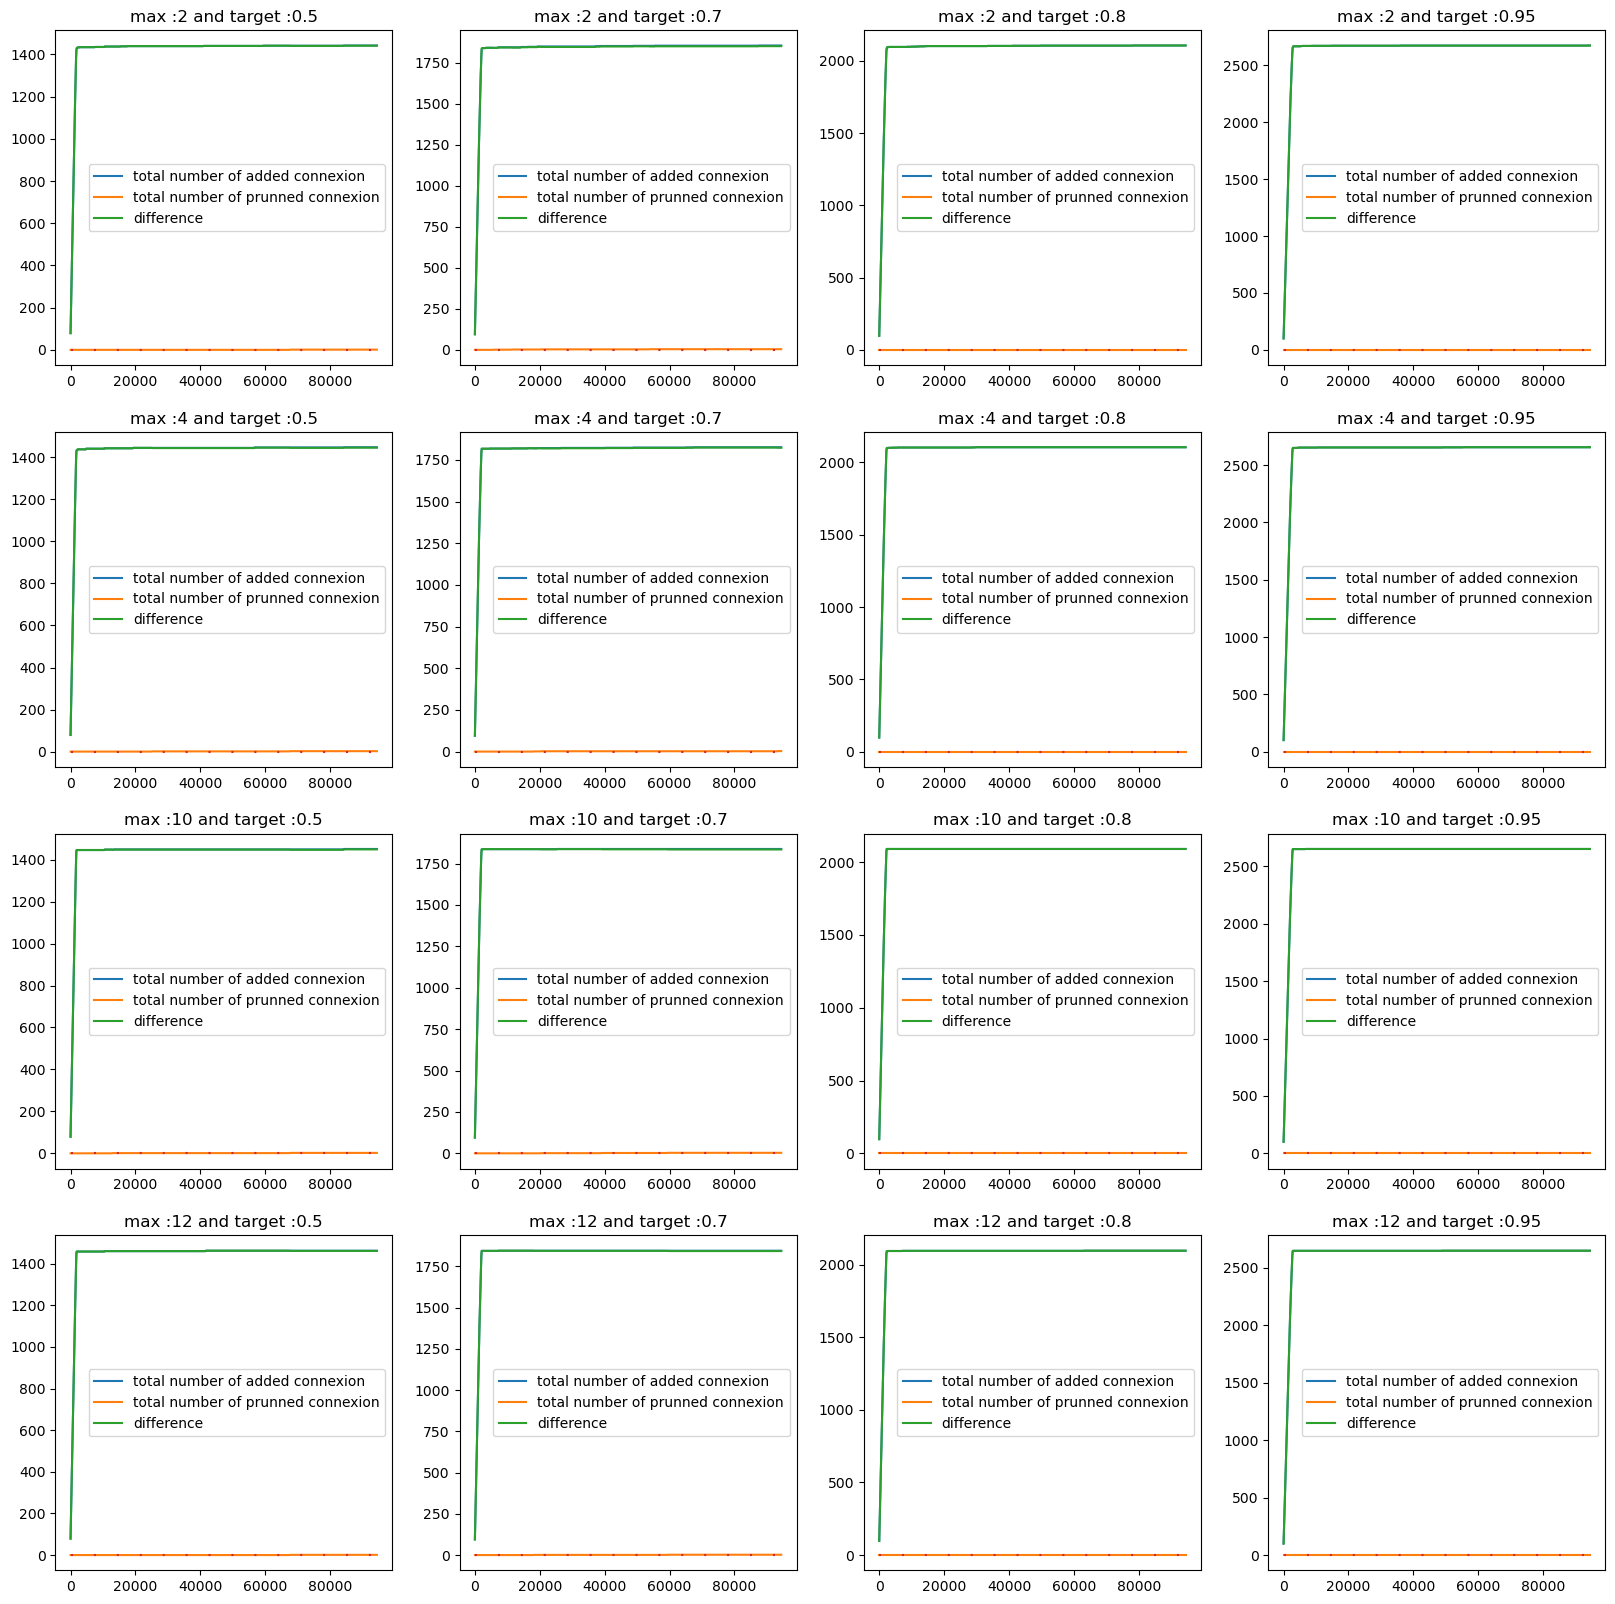

In [12]:
%matplotlib inline
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

growth_parameter = 0.1
TARGET_RATE_ARRAY = [0.5, 0.7, 0.8, 0.95]
MAX_CONNECTIONS_ARRAY = [2, 4, 10, 12]

# The parameters you want to see the influence
fig, ax = plt.subplots(len(MAX_CONNECTIONS_ARRAY), len(TARGET_RATE_ARRAY), figsize=(20, 20))
k = 0
for max_connections in MAX_CONNECTIONS_ARRAY:
    j = 0
    for target_rate in TARGET_RATE_ARRAY:
        # Initialisation
        W_ee_adsp = W_ee.copy()
        W_ie_adsp = W_ie.copy()
        W_ei_adsp = W_ei.copy()
        u_train_adsp1 = inputs1.copy()
        state_e = last_state_e
        state_i = last_state_i
        Win_e_adsp = Win_e

        step = 0

        total_add = 0
        total_prun = 0
        add = []
        prun = []
        mean_prun = []

        incoming_connexion_count_history = []
        state_history_e = []
        state_history_i = []

        for i in range(INCREMENT * 5):
            state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train_adsp1[:,i], state_e, state_i, leaky_rate, bias_e,
                                                       bias_i, activation_function)
            state_history_e.append(state_e)
            state_history_i.append(state_i)
        u_train_adsp1 = u_train_adsp1[:, INCREMENT * 5:]
        train_length = len(u_train_adsp1[1, :])

        while train_length > 5000:

            incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

            # For excitatory neurons (We and Wie)
            delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            W_ee_adsp, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE, max_connections=max_connections)

            # For inhibitory neurons (Wi)
            # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
            # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = bounded_adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

            for i in range(INCREMENT):
                state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train_adsp1[:,i], state_e, state_i, leaky_rate, 
                                                       bias_e, bias_i, activation_function)
                state_history_e.append(state_e)
                state_history_i.append(state_i)
            u_train_adsp1 = u_train_adsp1[:, INCREMENT:]
            train_length = len(u_train_adsp1[1, :])

            total_add += nb_new_add_e  # + nb_new_add_i
            total_prun += nb_new_prun_e # + nb_new_prun_i
            add.append(total_add)
            prun.append(total_prun)

            step += 1
        add = np.array(add)
        prun = np.array(prun)
        ax[k][j].plot(np.arange(step) * INCREMENT, add, label="total number of added connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, prun, label="total number of prunned connexion")
        ax[k][j].plot(np.arange(step) * INCREMENT, add - prun, label="difference")
        ax[k][j].plot(np.arange(step) * INCREMENT, [0] * step, linestyle=(0, (1, 10)))
        ax[k][j].title.set_text(f'max :{max_connections} and target :{target_rate}')
        ax[k][j].legend()
        j += 1
    k += 1


## Simulation

Excitatory neuron evolution is given by : 

$ r_E^{t+1} = W_{EE}r_E^{t} - W_{IE}r_I^{t} + W_{in}u^{t} + bias_E $

Inhibitory neurons evolution is given by : 

$ r_I^{t+1} = W_{EI}r_E^{t} + bias_I $


In [13]:
from reservoir.reservoir import init_matrices

# Parameters
n_e = 100 # number of neurons for excitatory pool
n_i = 0 # number of neurons for inhibitory pool
SEED = 65718 # previous 3789
leaky_rate = 1

spectral_radius = 1
input_connectivity =  1
connectivity_e = 0 # from the article
connectivity = 0.1 # from the article

# HYPERPARAMETERS
INCREMENT = 100
VALUE = 0.05
bias_scaling = 0.1
input_scaling = 1


# Initialisation EE
Win_e, W_ee, bias_e =  init_matrices(n_e, input_connectivity, connectivity_e, spectral_radius, seed=SEED)
bias_e = bias_e*bias_scaling
Win_e = Win_e*input_scaling

# Initialisation EI
_, W_ei, _ =  init_matrices((n_i, n_e), 0, connectivity, 1, seed=SEED)

# Initialisation IE
_, W_ie, _ =  init_matrices((n_e, n_i), 0, connectivity, 1, seed=SEED)

# Initialisation II
_, _, bias_i =  init_matrices(n_i, 0, connectivity, 1, seed=SEED)
bias_i = bias_i*bias_scaling

# last_state
last_state_e = np.random.uniform(0, 1, n_e)
last_state_i = np.random.uniform(0, 1, n_i)

In [14]:
import connexion_generation.bounded_adsp
from connexion_generation.bounded_adsp import bounded_adsp
reload(connexion_generation.bounded_adsp)
import connexion_generation.utility
from connexion_generation.utility import compute_synaptic_change
reload(connexion_generation.utility)

# Parameters
# The parameters you want to see the influence
growth_parameter = 0.1
target_rate=0.7

INCREMENT = 100
VALUE = 0.05

# Initialisation
W_ee_adsp = W_ee.copy()
W_ie_adsp = W_ie.copy()
W_ei_adsp = W_ei.copy()
u_train1 = inputs1.copy()
state_e = last_state_e
state_i = last_state_i
Win_e_adsp = Win_e

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
state_history_i = []
delta_z_e_history = []

for i in range(INCREMENT*5):
    state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train1[:, i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    state_history_e.append(state_e)
    state_history_i.append(state_i)
u_train1 = u_train1[:, INCREMENT * 5:]

In [15]:
train_length = len(u_train1[1, :])

while train_length > 10000:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp))

     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp, W_ie_adsp, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp, state_e, delta_z_e, VALUE, W_ie_adsp)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e_adsp, u_train1[:, i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        state_history_i.append(state_i)
    u_train1 = u_train1[:, INCREMENT:]
    train_length = len(u_train1[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

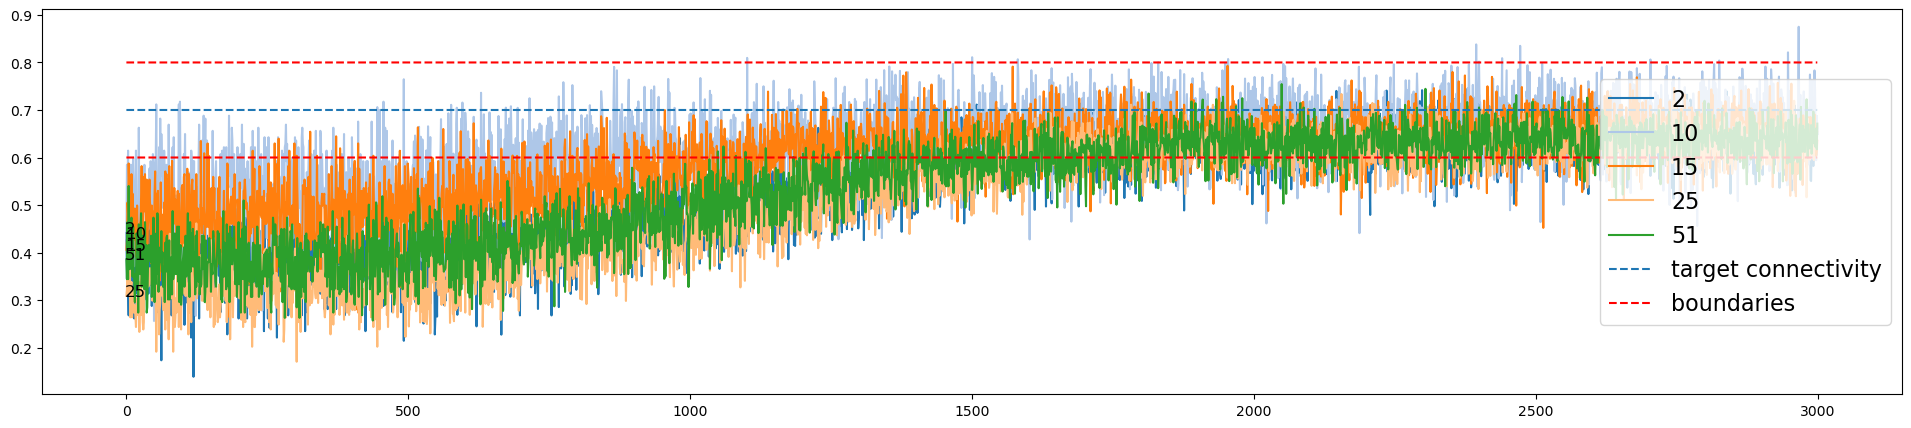

In [16]:
# NEURON ACTIVITY PLOT 
plt.figure(figsize=(24,5))
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 3000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    plt.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    plt.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
plt.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
plt.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
plt.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


## Analysis

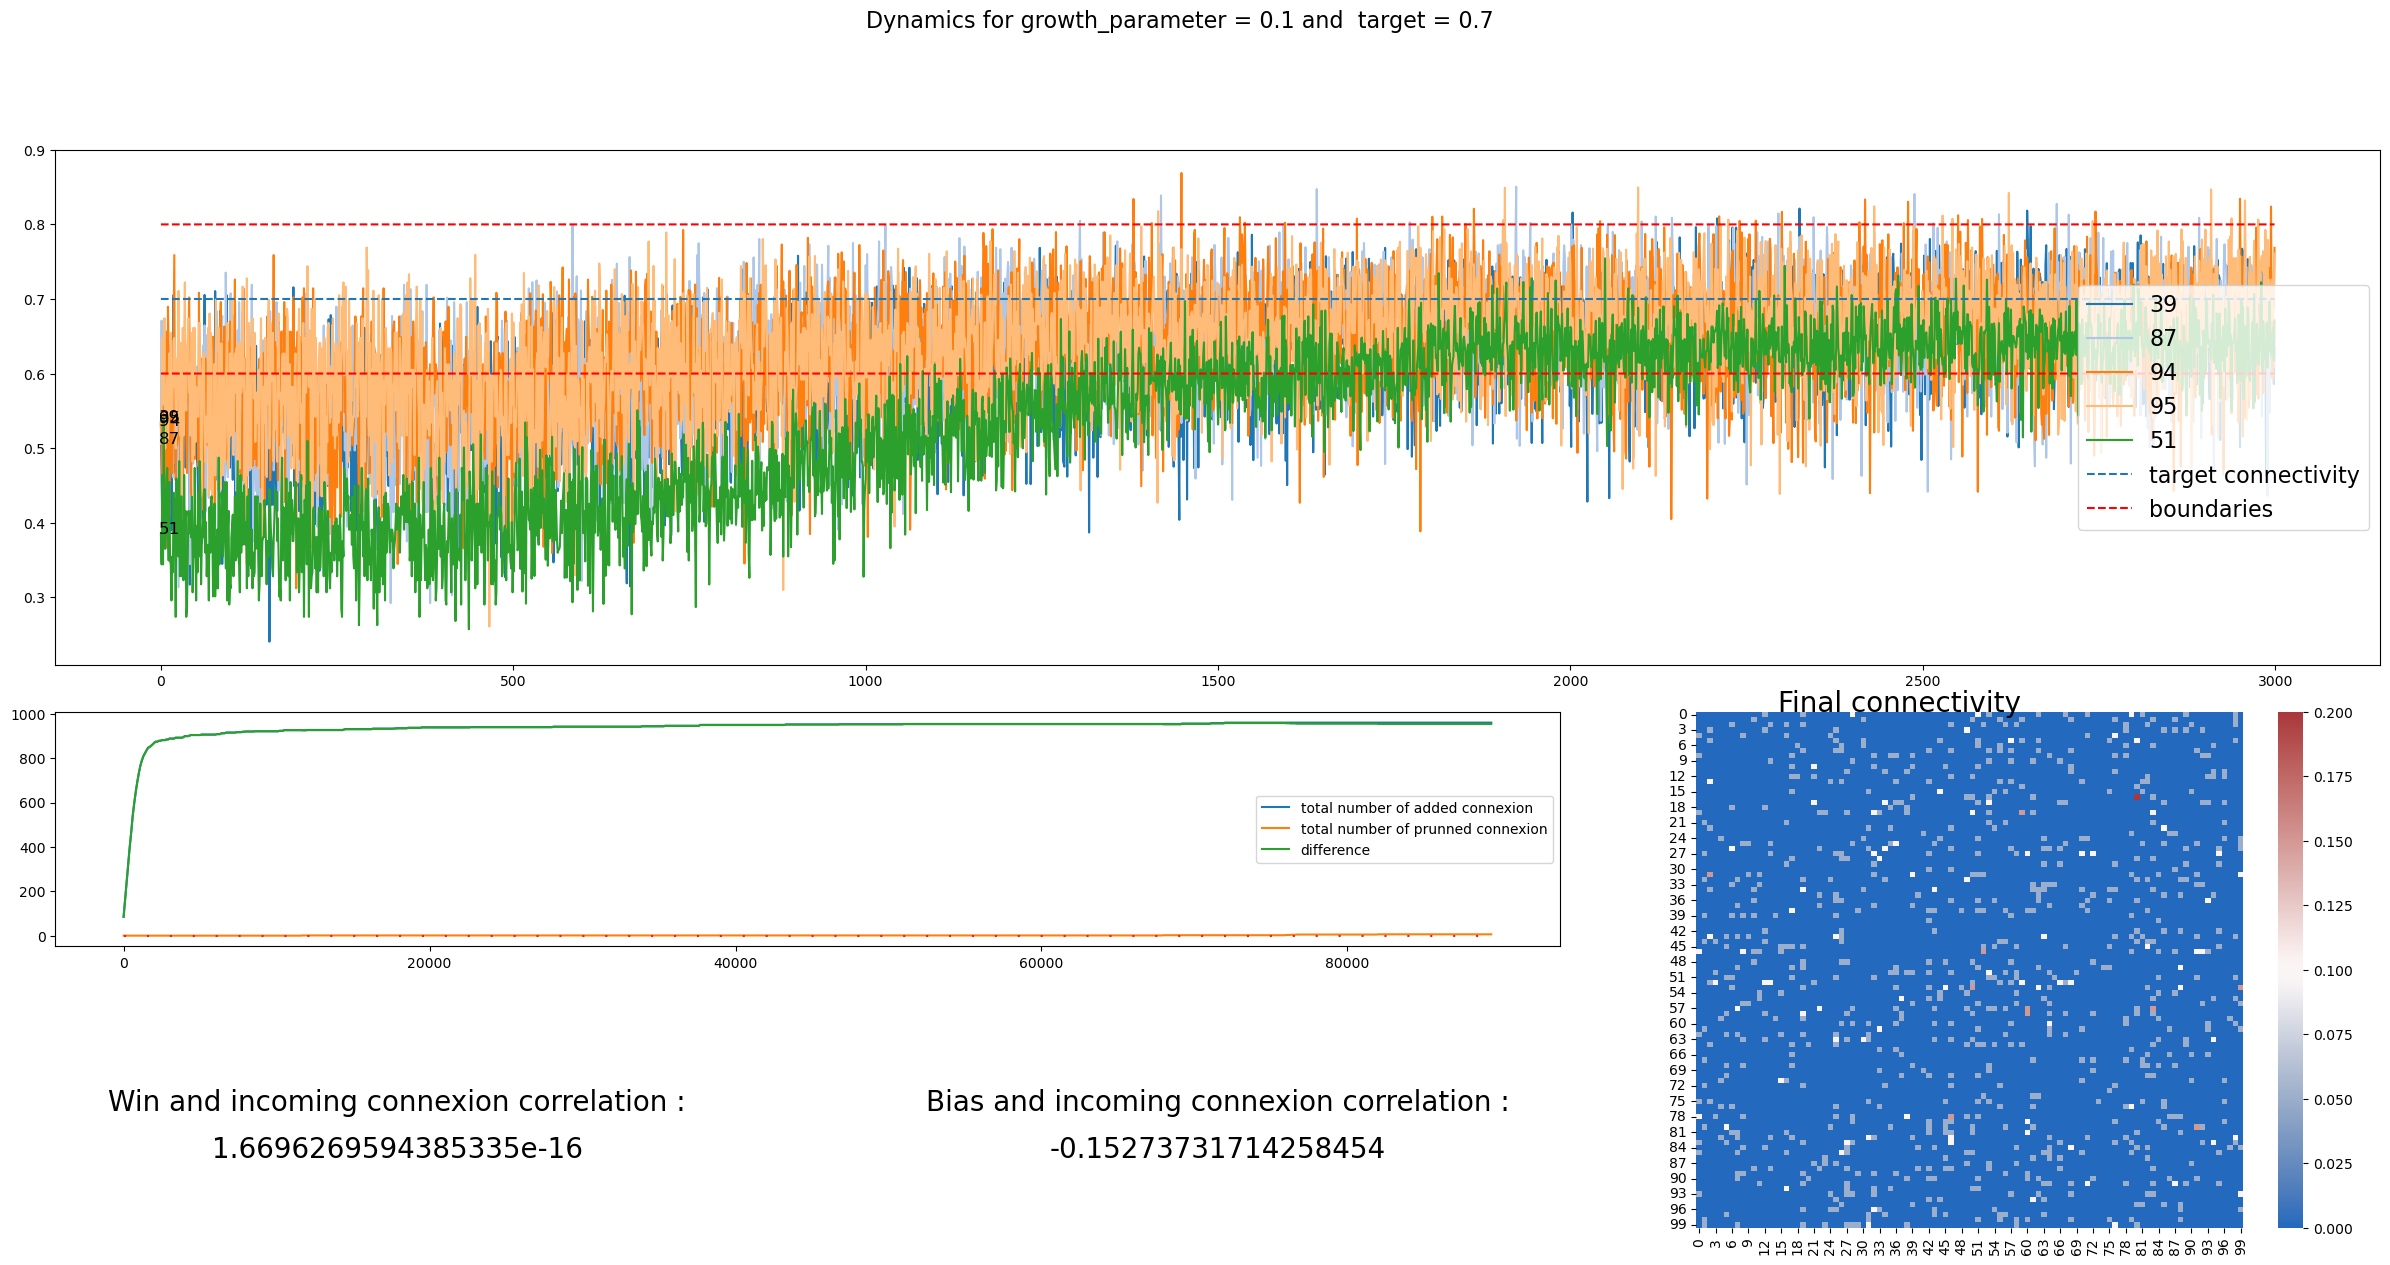

In [17]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=4)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 0
WATCH_TO = 3000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

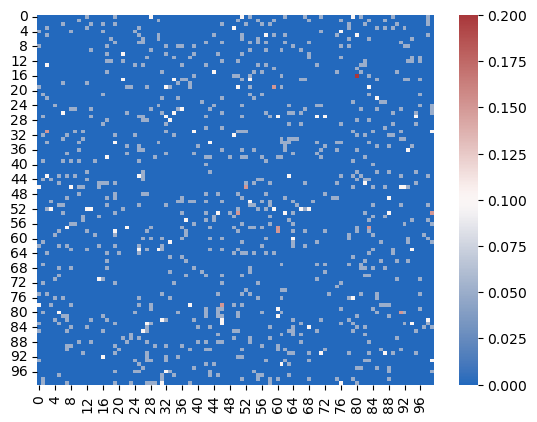

In [18]:
heatmap(W_ee_adsp.todense(), cmap=color_palette("vlag", as_cmap=True))

## Hebbian learning exemple

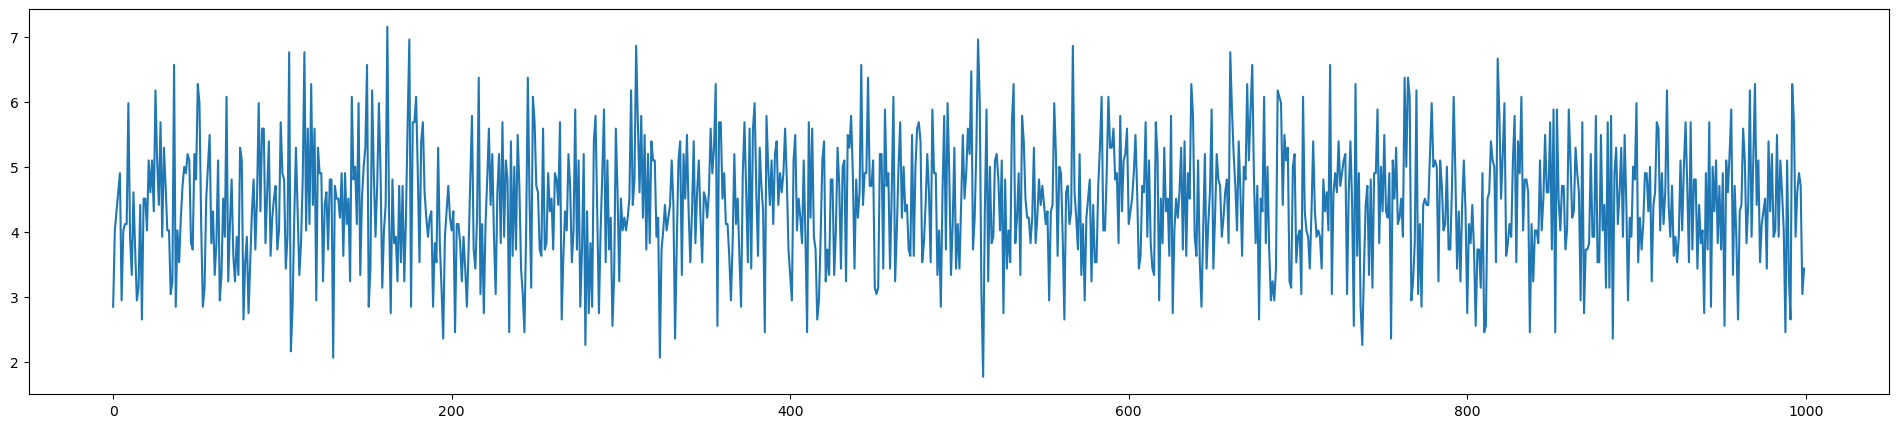

In [38]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs2 = (U - U.min()) / (U.max() - U.min())

inputs2[50:60,:] = inputs2[50:60,:]*10
plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs2[52,16000:17000])
plt.show()

In [39]:
u_train2 = inputs2.copy()

W_ee_adsp_hebbian = W_ee.copy()
W_ie_adsp_hebbian = W_ie.copy()
W_ei_adsp_hebbian = W_ei.copy()
Win_e_adsp_hebbian = Win_e

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
state_history_i = []
delta_z_e_history = []
train_length = len(u_train2[1, :])

while train_length > 500:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp_hebbian))

     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp_hebbian, W_ie_adsp_hebbian, W_ei_adsp_hebbian, Win_e_adsp_hebbian, u_train2[:, i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        state_history_i.append(state_i)
    u_train2 = u_train2[:, INCREMENT:]
    train_length = len(u_train2[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

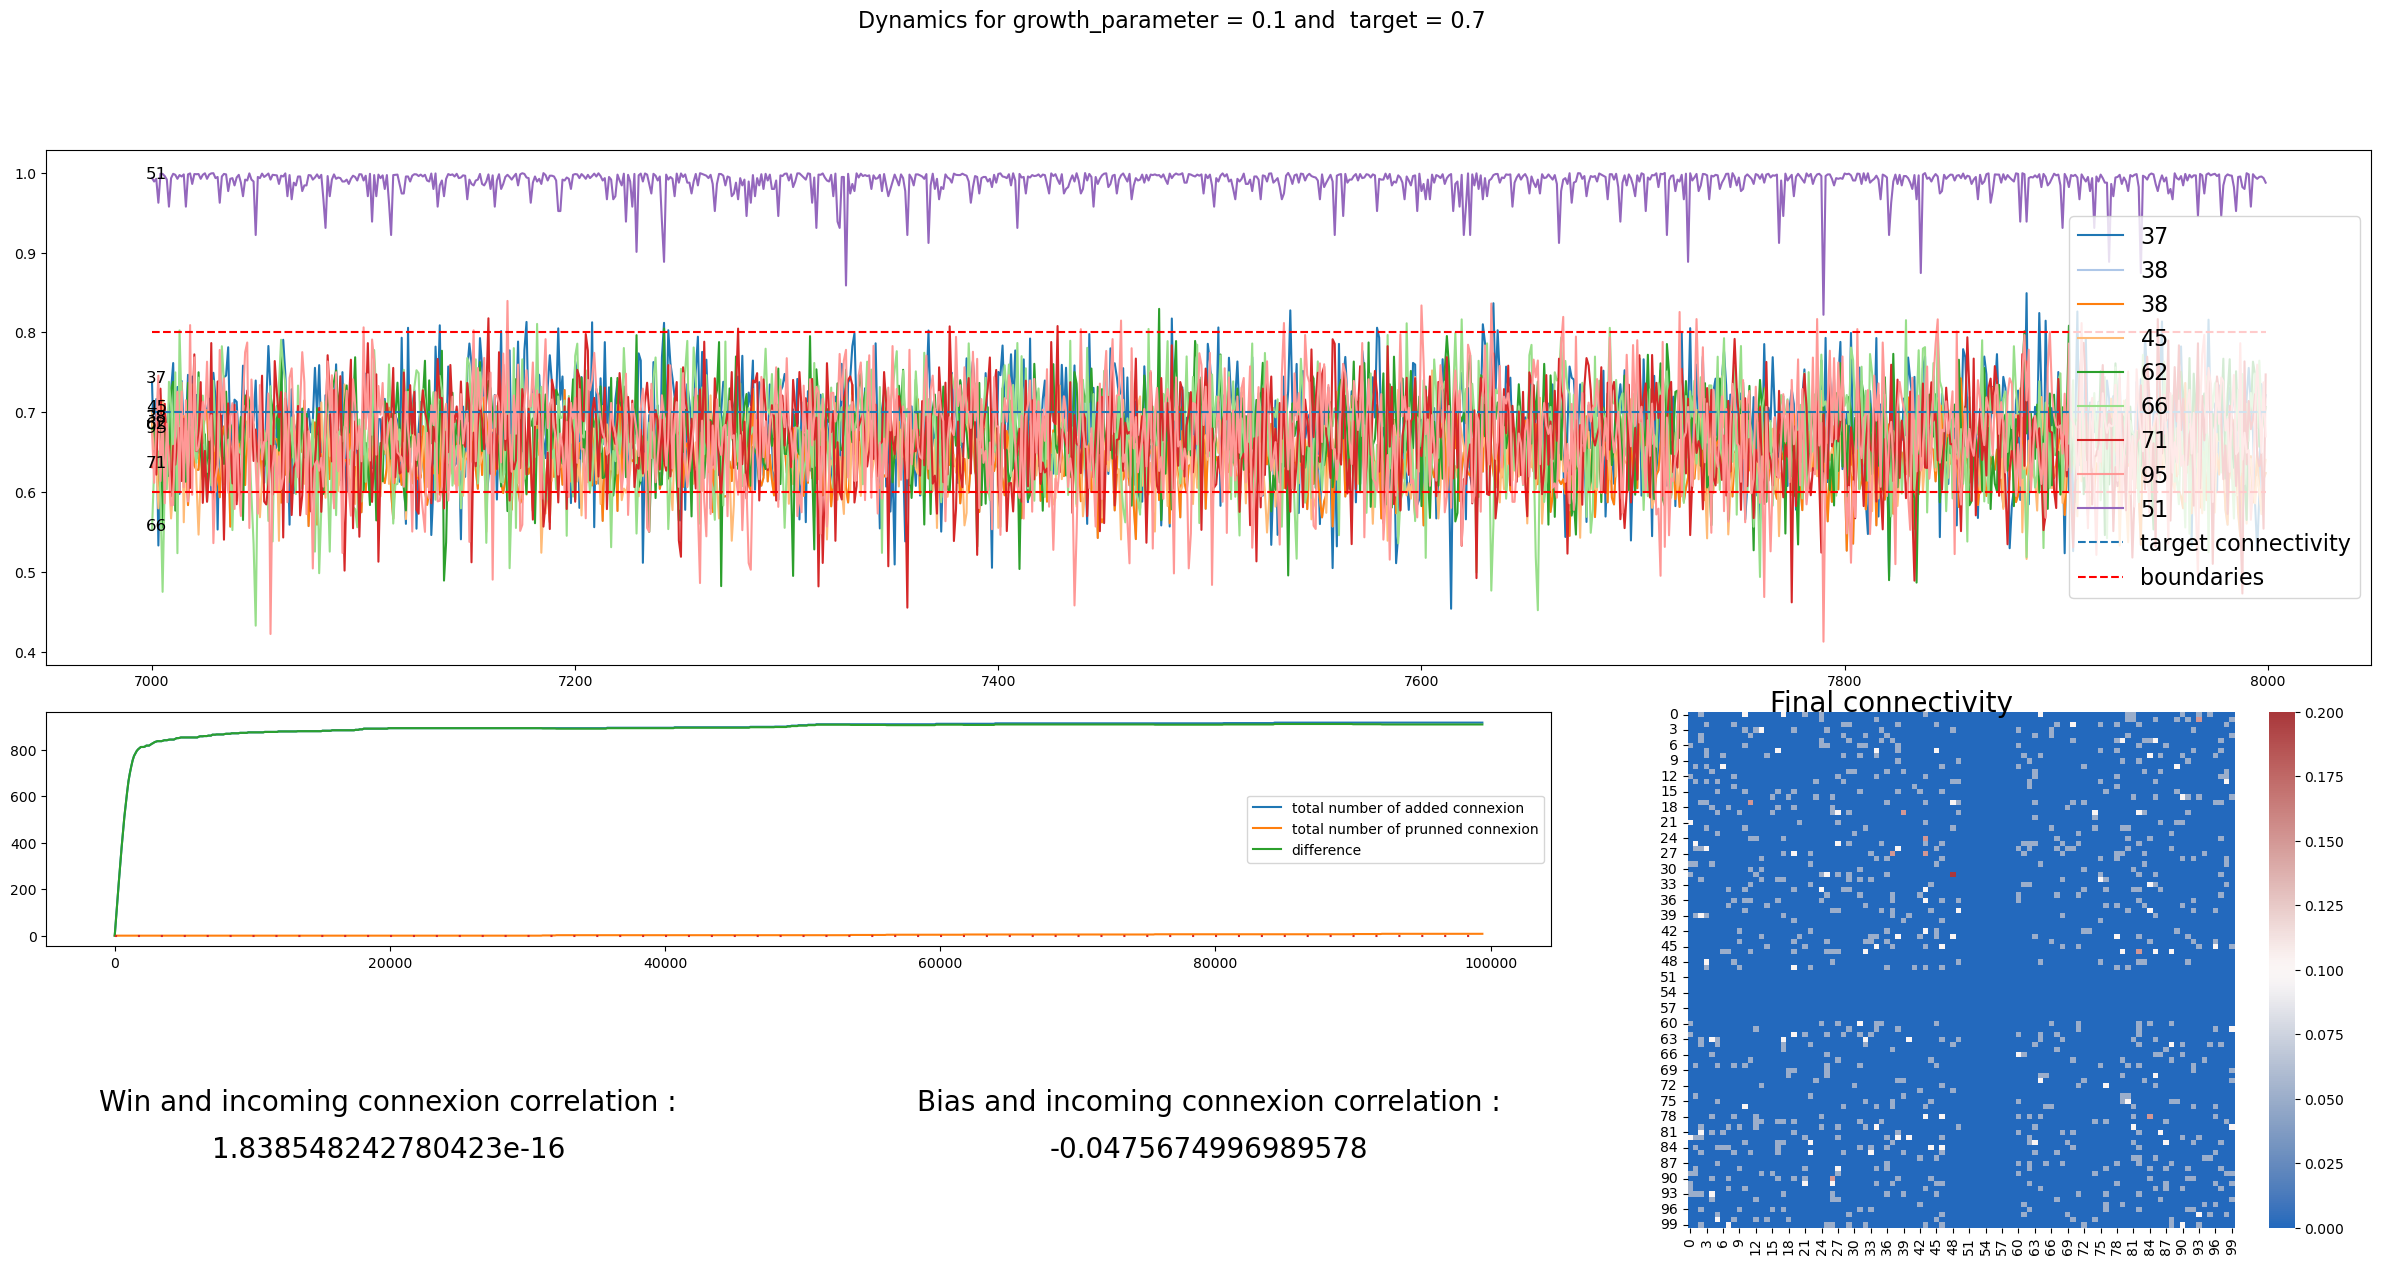

In [40]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

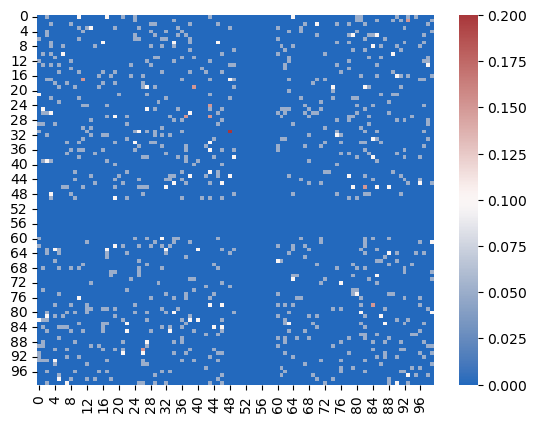

In [41]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True))

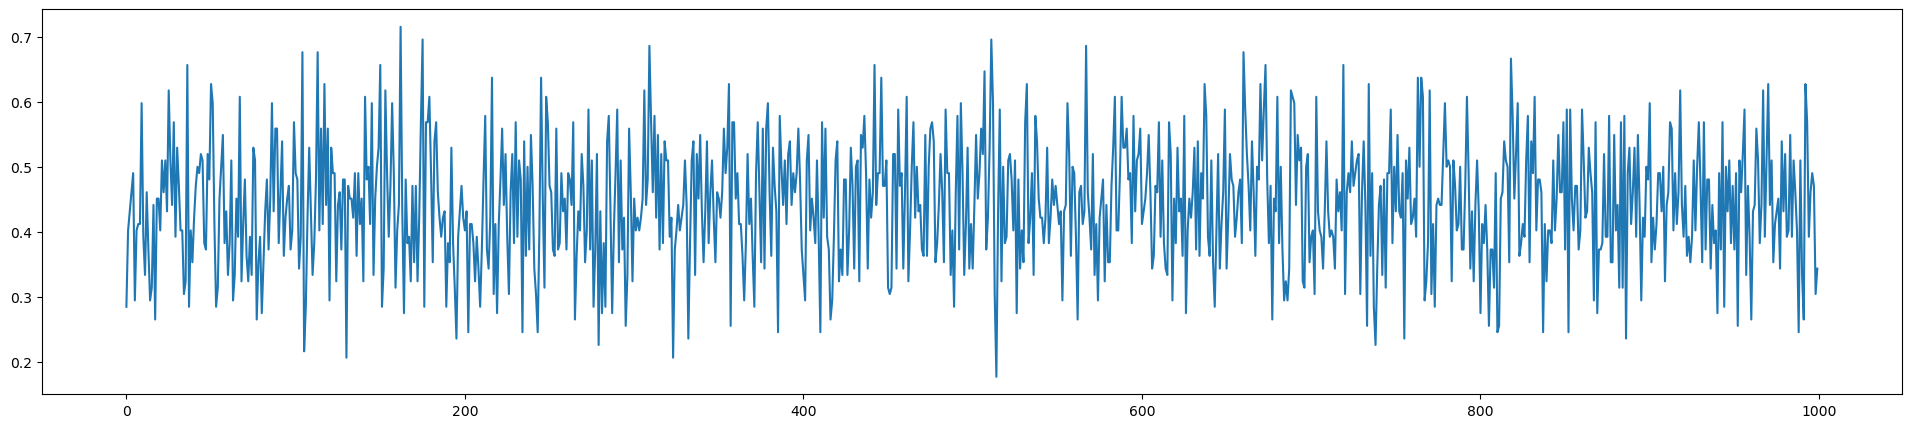

In [42]:
from scipy.stats import poisson

mu = 100
timesteps = 100000

U = poisson.rvs(mu, size=[timesteps, n_e], random_state = SEED)[np.newaxis].T

# rescale between 0 and 1
inputs3 = (U - U.min()) / (U.max() - U.min())

plt.figure(figsize=(24,5))
plt.plot(range(1000), inputs3[52,16000:17000])
plt.show()

In [43]:
u_train3 = inputs3.copy()

step=0

total_add = 0
total_prun = 0
add = []
prun = []
mean_prun = []

incoming_connexion_count_history = []
state_history_e = []
state_history_i = []
delta_z_e_history = []
train_length = len(u_train3[1, :])

while train_length > 500:

    incoming_connexion_count_history.append(count_incoming_connexions(W_ee_adsp_hebbian))

     # For excitatory neurons (We and Wie)
    delta_z_e = compute_synaptic_change(state_history_e[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    W_ee_adsp_hebbian, _, nb_new_add_e, nb_new_prun_e = bounded_adsp(W_ee_adsp_hebbian, state_e, delta_z_e, VALUE)
    delta_z_e_history.append(delta_z_e)
    
    # For inhibitory neurons (Wei)
    # delta_z_i = compute_synaptic_change(state_history_i[-INCREMENT:], target_rate, growth_parameter, average="QUEUE")
    # W_ei_adsp, _, nb_new_add_i, nb_new_prun_i = adsp(W_ei_adsp, state_i, delta_z_i, VALUE)

    for i in range(INCREMENT):
        state_e, state_i = update_ei_reservoir(W_ee_adsp_hebbian, W_ie_adsp_hebbian, W_ei_adsp_hebbian, Win_e_adsp_hebbian, u_train3[:, i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
        state_history_e.append(state_e)
        state_history_i.append(state_i)
    u_train3 = u_train3[:, INCREMENT:]
    train_length = len(u_train3[1, :])


    total_add += nb_new_add_e # + nb_new_add_i
    total_prun += nb_new_prun_e # + nb_new_prun_i
    add.append(total_add)
    prun.append(total_prun)
    step +=1
add = np.array(add)
prun = np.array(prun)

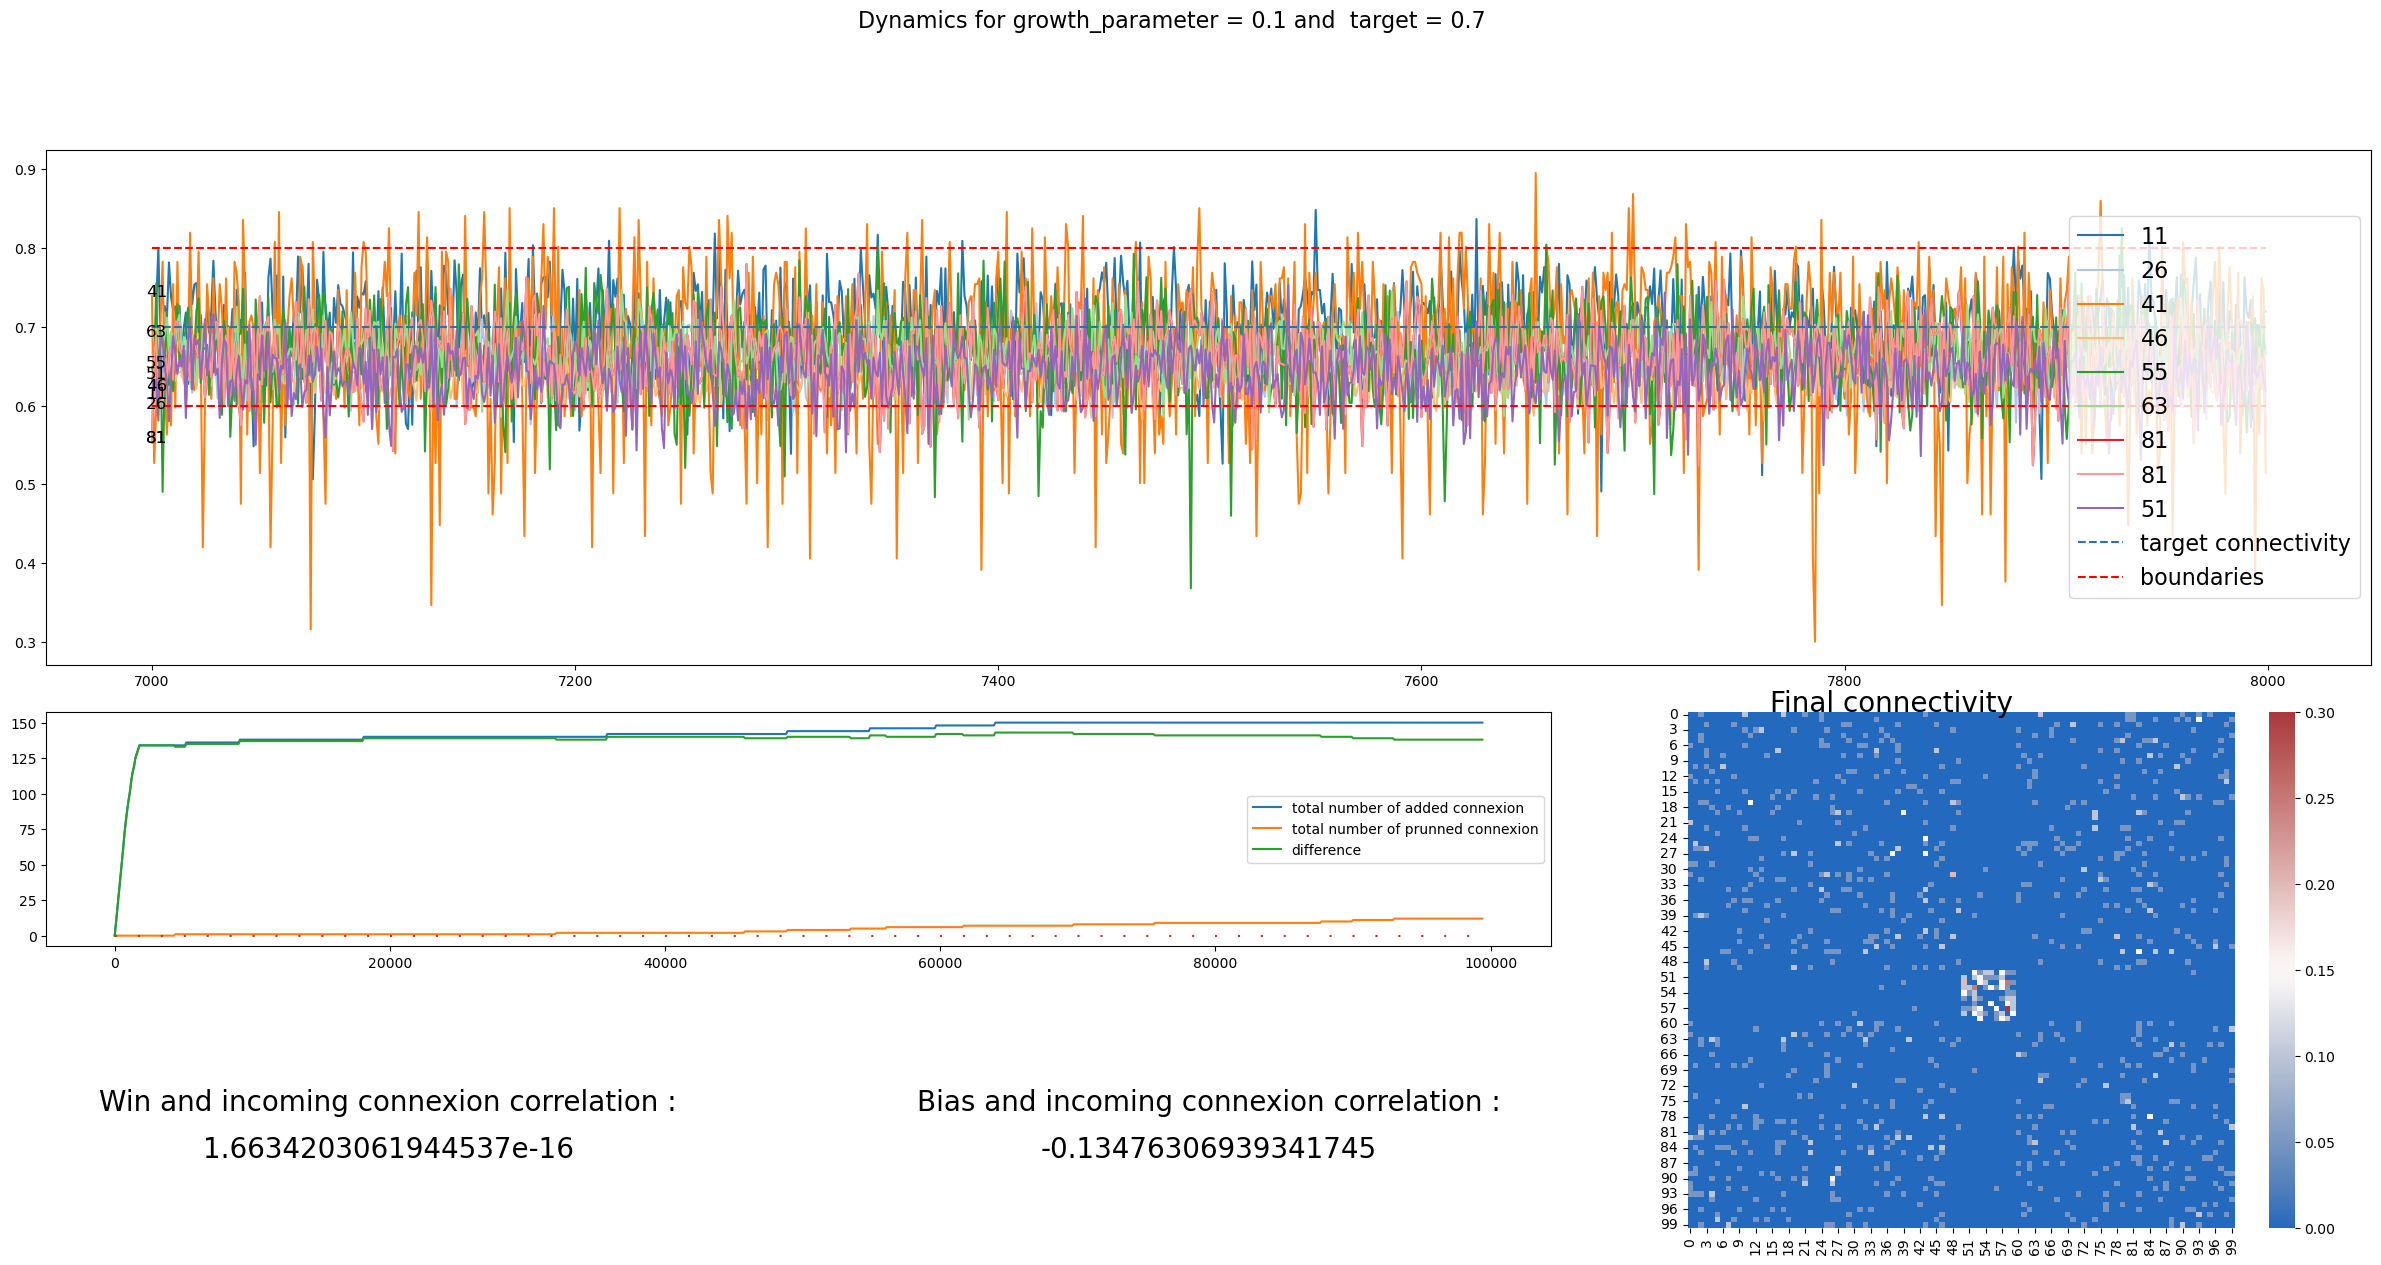

In [44]:
from math import copysign
from analysis.metrics import pearson 

plt.figure(figsize=(30,14))
plt.suptitle(f'Dynamics for growth_parameter = {growth_parameter} and  target = {target_rate}', fontsize=16)

# NEURON ACTIVITY PLOT 
ax0 = plt.subplot2grid((4, 3), (0, 0), colspan=3, rowspan=2)
random_neurons_indices =  np.sort(np.random.randint(n_e, size=8)) #Size max is 19 because there is not enough colors
random_neurons_indices = np.append(random_neurons_indices, 51)
colors = color_palette("tab20")
# NUMBER_OF_STEP_TO_WATCH 
WATCH_FROM = 7000
WATCH_TO = 8000
neurons_evolution = np.array(state_history_e)[WATCH_FROM:WATCH_TO]
x =range(len(state_history_e))[WATCH_FROM:WATCH_TO]
j = 0
for i in random_neurons_indices:
    ax0.plot(x, neurons_evolution[: ,i], label=str(i), color=colors[j])
    ax0.text(-3+WATCH_FROM, neurons_evolution[0, i],  str(i), color="black", fontsize=12)
    j += 1
ax0.plot(x, [target_rate]*(WATCH_TO-WATCH_FROM), linestyle = "--", label="target connectivity")
ax0.plot(x, [target_rate+growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--", label="boundaries")
ax0.plot(x, [target_rate-growth_parameter]*(WATCH_TO-WATCH_FROM), color="red", linestyle = "--")
# to watch the inputs simultaneously
# ax0.plot(x, inputs1[0, WATCH_FROM:WATCH_TO], color="blue", linestyle = "--")

plt.legend(fontsize=16, loc="right")


# TOTAL ADDITION AND PRUNING OF CONNEXIONS 
ax1 = plt.subplot2grid((4, 3), (2, 0), colspan=2)
ax1.plot(np.arange(step)*INCREMENT, add, label="total number of added connexion")
ax1.plot(np.arange(step)*INCREMENT, prun, label="total number of prunned connexion")
ax1.plot(np.arange(step)*INCREMENT, add-prun, label="difference")
ax1.plot(np.arange(step)*INCREMENT, [0]*step, linestyle=(0, (1, 10)))
ax1.legend()

# CONNEXION MATRICE
ax2 = plt.subplot2grid((4, 3), (2, 2), rowspan=2)
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True), ax = ax2)
ax2.text(15,0, 'Final connectivity',fontsize=20)

ax3 = plt.subplot2grid((4, 3), (3, 0))
ax3.text(0.5, 0.5, 'Win and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.text(0.5, 0.3, pearson(Win_e.A, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax3.transAxes)
ax3.axis('off')

ax4 = plt.subplot2grid((4, 3), (3, 1))
ax4.text(0.5, 0.5, 'Bias and incoming connexion correlation :',fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.text(0.5, 0.3, pearson(bias_e, incoming_connexion_count_history[-1]),fontsize=20,horizontalalignment='center',
        transform=ax4.transAxes)
ax4.axis('off')

plt.show()

<AxesSubplot: >

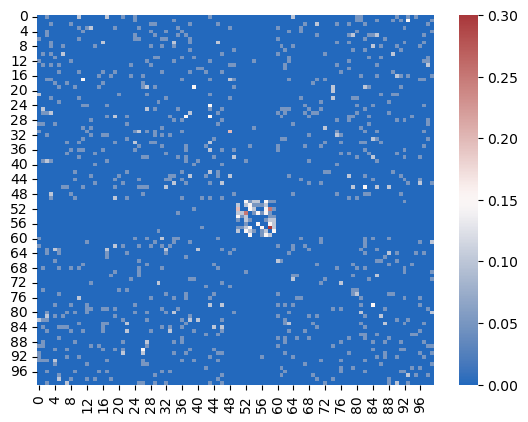

In [45]:
heatmap(W_ee_adsp_hebbian.todense(), cmap=color_palette("vlag", as_cmap=True))

# Measurement

## Richness in reservoir

### Spectral radius

In [ ]:
eigen = sparse.linalg.eigs(W, k=1, which="LM", maxiter=W.shape[0] * 20, tol=0.1, return_eigenvectors=False)
sr = max(abs(eigen))

### Memory capacity

$$  y_{d_i} = \prod_i{P_{d_i}(u(t-i))}$$

#### Without adsp

In [62]:
# Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
warmup_steps = 500
warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

# Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
steps = 1000000
inputs = 2.0*np.random.rand(steps,1)-1.0
connectivity_desired =  W_ee_adsp.count_nonzero() / (W_ee_adsp.shape[0] * W_ee_adsp.shape[1])
_, W_ee_w, _ =  init_matrices(n_e, input_connectivity, connectivity_desired, spectral_radius, seed=SEED)

for i in range(warmup_steps):
    state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, warmups[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)

capa_history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee_w, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    capa_history_e.append(state_e)
capa_history_e = np.array(capa_history_e)
connectivity_desired

0.0895

In [56]:
import analysis.capacities as CAP

# Measallcapsure capacities on inputs and states after removing a "warmup period"
# If you require more extensive printed output of individual capacities:
# set verbose = 1
Citer=CAP.capacity_iterator(maxdeg=7)#, verbose = 1)
totalcap,allcaps,numcaps,nodes = Citer.collect(inputs,capa_history_e)

print("\nMeasured ",numcaps," capacities above threshold.\nTotal capacity = ",totalcap)

Estimated rank of state covariance matrix =  100
Total score for degree  1  =  5.898090693505408 (cumulative total =  5.898090693505408 )
Total score for degree  2  =  8.123242416436682 (cumulative total =  14.021333109942091 )
Total score for degree  3  =  21.942611485959667 (cumulative total =  35.96394459590173 )
Total score for degree  4  =  7.948941622632491 (cumulative total =  43.912886218534304 )
Total score for degree  5  =  19.95007088567796 (cumulative total =  63.86295710421247 )
Total score for degree  6  =  5.01841915458952 (cumulative total =  68.88137625880209 )
Total score for degree  7  =  9.265448926279367 (cumulative total =  78.1468251850815 )
Total score for degree  8  =  3.4383251974887474 (cumulative total =  81.58515038257012 )
Total capacity=81.585 (81.59 percent)

Measured  35883  capacities above threshold.
Total capacity =  81.58515038257012


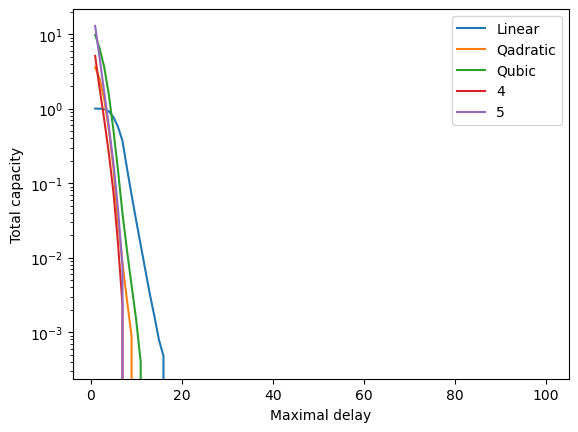

In [48]:
# Helper function to use the capacities data structure coming out of the iterator
# cap2vec collates all capacities with same maximal delay and degree up to given maximal values
def cap2vec(capacities,maxdel=1000,maxdeg=10):
    vec = np.zeros((maxdel,maxdeg))
    for idx in range(len(capacities)):
        delay=capacities[idx]['delay']
        degree=capacities[idx]['degree']
        if (delay<=maxdel) and (degree<=maxdeg):
            vec[delay-1,degree-1]+=capacities[idx]['score']
    return vec

maxdel = 100
maxdeg = 10
V = cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure()
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

#### With adsp

In [49]:
# Number of time steps: you can use 1e5 for quick-and-dirty, but 1e6 is better
warmup_steps = 500
warmups = 2.0*np.random.rand(warmup_steps,1)-1.0

# Important: capacity theory with Legendre polynomials assumes uniform random inputs in [-1,1]
steps = 1000000
inputs = 2.0*np.random.rand(steps,1)-1.0

state_e_adsp = last_state_e
state_i_adsp = last_state_i
for i in range(warmup_steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, warmups[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)

capa_history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    capa_history_e_adsp.append(state_e_adsp)
capa_history_e_adsp = np.array(capa_history_e_adsp)

In [50]:
import analysis.capacities as CAP

# Measallcapsure capacities on inputs and states after removing a "warmup period"
# If you require more extensive printed output of individual capacities:
# set verbose = 1
Citer=CAP.capacity_iterator(maxdeg=7)#, verbose = 1)
totalcap_adsp,allcaps_adsp,numcaps_adsp,nodes = Citer.collect(inputs,capa_history_e_adsp)

print("\nMeasured ",numcaps_adsp," capacities above threshold.\nTotal capacity = ",totalcap_adsp)

Estimated rank of state covariance matrix =  100
Total score for degree  1  =  6.501792211597232 (cumulative total =  6.501792211597232 )
Total score for degree  2  =  11.282637932938721 (cumulative total =  17.784430144535964 )
Total score for degree  3  =  26.08116422644398 (cumulative total =  43.86559437097992 )
Total score for degree  4  =  13.742198891468371 (cumulative total =  57.607793262448276 )
Total score for degree  5  =  24.076585686885185 (cumulative total =  81.68437894933335 )
Total score for degree  6  =  5.555301594229502 (cumulative total =  87.2396805435629 )
Total score for degree  7  =  8.702703960511442 (cumulative total =  95.94238450407455 )
Total capacity=95.942 (95.94 percent)

Measured  9901  capacities above threshold.
Total capacity =  95.94238450407455


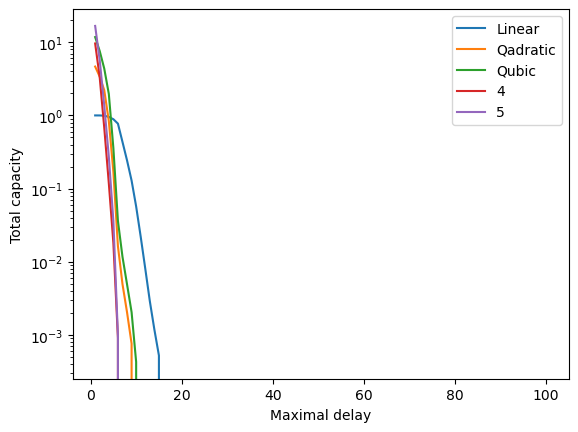

In [51]:
maxdel = 100
maxdeg = 10
V = cap2vec(allcaps_adsp,maxdel = maxdel, maxdeg = maxdeg)

delrange = np.arange(1,maxdel+1)
totcap = np.sum(V,axis=1)
plt.figure()
plt.semilogy(delrange,V[:,0],label='Linear')
plt.plot(delrange,V[:,1],label='Qadratic')
plt.plot(delrange,V[:,2],label='Qubic')
plt.plot(delrange,V[:,3],label='4')
plt.plot(delrange,V[:,4],label='5')

plt.xlabel('Maximal delay')
plt.ylabel('Total capacity')
plt.legend()
plt.show()

#### Comparaison

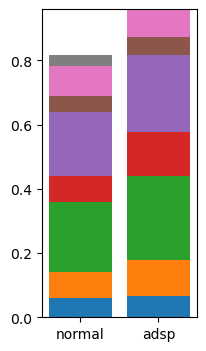

In [61]:
maxdel = 100
maxdeg = 8
plt.figure(figsize=(2,4))
V = cap2vec(allcaps,maxdel = maxdel, maxdeg = maxdeg)
V_adsp = cap2vec(allcaps_adsp,maxdel = maxdel, maxdeg = maxdeg)
values = np.mean(V, axis=0)
values_adsp = np.mean(V_adsp, axis=0)
height = 0
for i, v in enumerate(values):
    plt.bar(0, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

height = 0
for i, v in enumerate(values_adsp):
    plt.bar(1, v, bottom=height, color=plt.cm.tab10(i))
    height = height + v

plt.xticks([0, 1], ('normal', 'adsp'))
plt.show()

### Uncoupled dynamics

number of the principal components (i.e. orthogonal diretions of variability) that are able to explain the most of the variance in the reservoir state space

https://arxiv.org/pdf/1903.05174.pdf

$$ UD =  \underset{d}{\arg\min} \{ \sum\limits_{k=1}^d R_k|\sum\limits_{k=1}^dR_k ≥ A\}$$

with  $R_k = \frac{σ_k}{\sum\limits_{j=1}^{N_R}σ_j} $

In [63]:
from analysis.metrics import uncoupled_dynamics
from reservoirpy.datasets import mackey_glass
from reservoirpy.observables import nrmse, rsquare

timesteps = 20000
warmup_steps = 500
steps = timesteps + warmup_steps
tau = 17
# X = mackey_glass(steps, tau=tau)
X = 2.0*np.random.rand(steps,1)-1.0
# rescale between -1 and 1
inputs = 2 * (X - X.min()) / (X.max() - X.min()) - 1

## Calculous for simple RNN
state_e = last_state_e
state_i = last_state_i
history_e = []
for i in range(steps):
    state_e, state_i = update_ei_reservoir(W_ee, W_ie, W_ei, Win_e, inputs[i], state_e, state_i, leaky_rate, bias_e, bias_i, activation_function)
    history_e.append(state_e)
history_e = np.array(history_e)[warmup_steps:]
UD = uncoupled_dynamics(history_e, temp = 5000, A= 0.9)
print(UD)

## Calculous for adsp RNN
state_e_adsp = last_state_e
state_i_adsp = last_state_i
history_e_adsp = []
for i in range(steps):
    state_e_adsp, state_i_adsp = update_ei_reservoir(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, inputs[i], state_e_adsp, state_i_adsp, leaky_rate, bias_e, bias_i, activation_function)
    history_e_adsp.append(state_e_adsp)
history_e_adsp = np.array(history_e_adsp)[warmup_steps:]
UD_adsp = uncoupled_dynamics(history_e_adsp, temp = 5000, A= 0.9)

print(UD_adsp)


(1, 0.9046691798281126)
(3, 0.9153663542052891)


### Pearson coeffcients

$$ corr(x_i(t), x_k(t+1))) = \frac{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})(x_k(t)-\bar{x_k})}} {\sqrt{\sum\limits_{t=1}^{T-1}{(x_i(t)-\bar{x_i})^2}}\sqrt{\sum\limits_{t=1}^{T-1}{(x_k(t)-\bar{x_k})^2}}} $$

<AxesSubplot: >

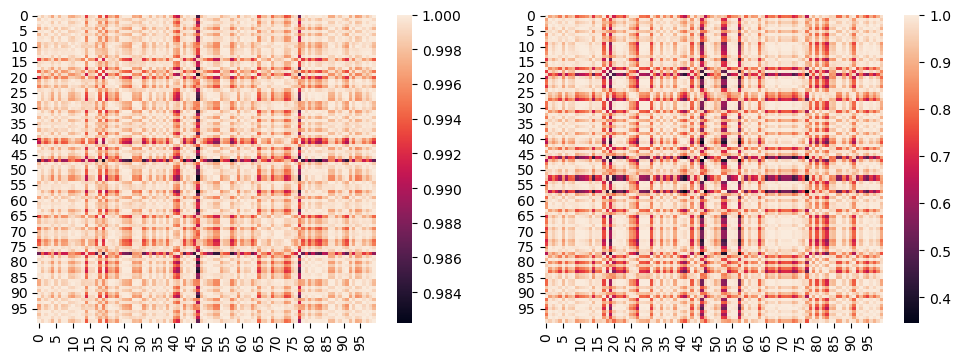

In [64]:
from analysis.metrics import pearson_matrix

plt.figure(figsize=(12,4))

ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e[:20000,])
heatmap(Pearson)

ax1 = plt.subplot2grid((1, 2), (0, 1), colspan=1, rowspan=1)
Pearson = pearson_matrix(history_e_adsp[:20000,])
heatmap(Pearson)

The mean Pearson coefficient is given by

$$ \bar{Corr} = \frac{1}{N^2} \sum\limits_{i=1}^{N}\sum\limits_{k=1}^{N}corr(x_i(t), x_k(t+1)) $$

In [65]:
print(np.mean(pearson_matrix(history_e[:20000,])))
print(np.mean(pearson_matrix(history_e_adsp[:20000,])))

0.9982496649154142
0.9111312188761956


### Average State Entropy

efficient estimator of Renyi’s quadratic entropy 

https://arxiv.org/pdf/1903.05174.pdf

https://www.researchgate.net/publication/2818138_Information-Theoretic_Learning_Using_Renyi's_Quadratic_Entropy4

*"H(t) which is the sum of all pairs of interactions can be regarded as an overall potential energy of the data set. We will call this potential energy an information potential (IP). So **maximizing entropy** becomes equivalent to **minimizing information potential**"*


https://ia800704.us.archive.org/view_archive.php?archive=/24/items/wikipedia-scholarly-sources-corpus/10.1162.zip&file=10.1162%252Fneco.2007.19.1.111.pdf



$$H(t) = −log( \frac{1}{N_R^2}\sum\limits_{j=1}^{N_R}(\sum\limits_{i=1}^{N_R}G _{0.3}(x_j(t) - x_i (t))))$$

In [66]:
from analysis.metrics import renyi_entropy

In [67]:
print(np.mean(renyi_entropy(history_e[:20000,])))
print("adsp", np.mean(renyi_entropy(history_e_adsp[:20000,])))

-0.018799255643614055
adsp -0.39183064329765593


## Topology

In [68]:
%matplotlib inline
%matplotlib --list

Available matplotlib backends: ['tk', 'gtk', 'gtk3', 'gtk4', 'wx', 'qt4', 'qt5', 'qt6', 'qt', 'osx', 'nbagg', 'webagg', 'notebook', 'agg', 'svg', 'pdf', 'ps', 'inline', 'ipympl', 'widget']


In [69]:
from analysis.topology import create_network, draw_network

g = create_network(W_ee, Win_e)
draw_network(g, n_e)

/home/idlab278/Code/structural_plasticity/adsp/analysis/topology.py:10: RuntimeWarning: invalid value encountered in divide
  W = W.toarray() / np.amax(W)


ValueError: could not broadcast input array from shape (100,1) into shape (100,)

In [ ]:
g = create_network(W_ee_adsp)
draw_network(g, n_e)

### Connexion number histogram

In [ ]:
# Incoming connexions histogram
def plot_incoming_co_histogram(W_ee, W_ei, W_ie, ax=None):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=1)
    connections_ie = np.sum(np.where(W_ie <= 0, W_ie, 1), axis=1)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

# Incoming connexions histogram
def plot_outcoming_co_histogram(W_ee, W_ei, W_ie, ax=ax1):
    connections_ee = np.sum(np.where(W_ee <= 0, W_ee, 1), axis=0)
    connections_ie = np.sum(np.where(W_ei <= 0, W_ei, 1), axis=0)
    incoming_co = connections_ee + connections_ie
#    print(incoming_co)
    n_bins = int(np.max(incoming_co)+1)
    if ax == None:
        plt.figure()
        ax = plt
    ax.hist(incoming_co, bins=n_bins, ec="yellow")

fig = plt.figure(figsize=(16,8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
plot_incoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax1)
ax1.set_ylabel("connexions before adsp")
ax1.set_title("Incoming connexions")


ax2 = fig.add_subplot(gs[0, 1])
plot_outcoming_co_histogram(W_ee.A, W_ei.A, W_ie.A, ax=ax2)
ax2.set_title("Outcoming connexions")

ax3 = fig.add_subplot(gs[1, 0])
plot_incoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax3)
ax3.set_ylabel("connexions after adsp")

ax4 = fig.add_subplot(gs[1, 1])
plot_outcoming_co_histogram(W_ee_adsp.A, W_ei_adsp.A, W_ie_adsp.A, ax=ax4)


In [ ]:
from graph_tool.all import GraphView, corr_hist
g = create_network(W_ee)

gv= GraphView(g, directed=False)
h = corr_hist(g, "out", "out")

plt.clf()
plt.xlabel("Source out-degree")

plt.ylabel("Target out-degree")

plt.imshow(h[0].T, interpolation="nearest", origin="lower")

plt.colorbar()


### Centrality
https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust

#### Katz centrality

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/Katz_centrality
# https://graph-tool.skewed.de/static/doc/centrality.html#graph_tool.centrality.katz
from graph_tool.all import katz, graph_draw, prop_to_size, arf_layout
import matplotlib

g = create_network(W_ee)

x = katz(g, weight=g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=x,
              vertex_size=prop_to_size(x, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=x)

#### EigenTrust

In [ ]:
# The Katz centrality is the solution of the nonhomogeneous linear system x = alpha * A * x + betha
# https://en.wikipedia.org/wiki/EigenTrust
# https://graph-tool.skewed.de/static/doc/centrality.html?highlight=eigentrust#graph_tool.centrality.eigentrust
from graph_tool.all import eigentrust, graph_draw, prop_to_size
import matplotlib

g = create_network(W_ee)

t = eigentrust(g, g.ep["edge_pen_weight"])
pos = arf_layout(g)

graph_draw(g, pos=pos, vertex_fill_color=t,
              vertex_size=prop_to_size(t, mi=5, ma=15),
              vcmap=matplotlib.cm.gist_heat,
              vorder=t)

### Shortest path

In [ ]:
from graph_tool.all import count_shortest_paths

g = create_network(W_ee)
n_paths = count_shortest_paths(g, 12, 35)

print(n_paths)

### Correlation
https://graph-tool.skewed.de/static/doc/correlations.html#graph_tool.correlations.corr_hist

In [ ]:
from graph_tool.all import GraphView, assortativity, scalar_assortativity
g = create_network(W_ee)

# Return the assortativity coefficient, and its variance.
gv= GraphView(g, directed=False)
print(assortativity(gv, "out"))
print(scalar_assortativity(gv, "out"))

# Benchmarks

https://www.sciencedirect.com/science/article/pii/S092523122100775X?via%3Dihub


In [ ]:
def createNARMA(length=10000, system_order=10, coef = [.3, .05, 1.5, .1]):

    inputs = np.random.rand(length, 1) * .5
    inputs.shape = (-1, 1)
    outputs = np.zeros((length, 1))
    for k in range(system_order - 1, length - 1):
        outputs[k + 1] = coef[0] * outputs[k] + coef[1] * \
                                           outputs[k] * np.sum(outputs[k - (system_order - 1):k + 1]) + \
                         coef[2] * inputs[k - (system_order-1)] * inputs[k] + coef[3]
    return inputs, outputs


def createNARMA10(length=10000):
    return createNARMA(length=length, system_order=10, coef=[.3, .05, 1.5, .1])


def createNARMA30(length=10000):
    return createNARMA(length=length, system_order=30, coef=[.2, .04, 1.5, .001])


timesteps = 100000 
train_samples = 10000
test_lenght = 5000

u, y = createNARMA30(timesteps)

U_train, y_train = u[:train_samples], y[:train_samples]
U_test, y_test = u[train_samples:], y[train_samples:]

%matplotlib inline
plt.figure(figsize=(16,5))
plt.plot(range(200), U_train[:200])
plt.show()

## Ridge search throughout cross validation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from reservoir.losses import nrmse
from reservoir.reservoir import train_ei, run_ei

# k -fold walk forward validation
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.8 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]
            
# Parameters
mean_nrmse_list = []
ridge_coef_list = []

# Index spliting
n_fold = 4
tscv = BlockingTimeSeriesSplit(n_splits=n_fold)

for ridge_coef in np.logspace(-10, 3,  num=20):
    for train_index, val_index in tscv.split(U_train):
#        print("TRAIN:", train_index[0], val_index[-1], "VALIDATION:", test_index[0], val_index[-1]) 
        U_cv_train, U_cv_val = U_train[train_index], U_train[val_index]
        y_cv_train, y_cv_val = y_train[train_index], y_train[val_index]

        mean_nrmse = 0


        # Training output
        Wout, b_out, last_state_e, last_state_i = train_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, U_cv_train, y_cv_train, activation_function, ridge_coef = ridge_coef)

        # Prediction
        y_cv_pred = run_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_cv_val, activation_function, b_out, 1, last_state_e, last_state_i)
        mean_nrmse = mean_nrmse + float(nrmse(y_cv_pred, y_cv_val))/n_fold

    mean_nrmse_list.append(mean_nrmse)
    ridge_coef_list.append(ridge_coef)

min_val_idx = [i for i in range(len(mean_nrmse_list)) if mean_nrmse_list[i]==min(mean_nrmse_list)][0]

print(ridge_coef_list[min_val_idx])

ridge_coef = ridge_coef_list[min_val_idx]

## Train 

In [ ]:
import reservoir.reservoir
from reservoir.reservoir import train_ei
reload(reservoir.reservoir)

# Training output
Wout, b_out, last_state_e, last_state_i = train_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


In [ ]:
from reservoir.reservoir import run_ei
from reservoir.reservoirpy_util import plot_results, plot_readout

# Prediction
y_pred = run_ei(W_ee, W_ie, W_ei, Win_e, bias_e, bias_i, Wout, U_test, activation_function, b_out, 1, last_state_e, last_state_i)

plot_results(y_pred, y_test, sample=200)

In [ ]:
# Training output
Wout_adsp, b_out_adsp, last_state_e_adsp, last_state_i_adsp = train_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, U_train, y_train, activation_function, ridge_coef = ridge_coef)


In [ ]:
# Prediction
y_pred_adsp = run_ei(W_ee_adsp, W_ie_adsp, W_ei_adsp, Win_e, bias_e, bias_i, Wout_adsp, U_test, activation_function, b_out_adsp, 1, last_state_e_adsp, last_state_i_adsp)

plot_results(y_pred_adsp, y_test, sample=200)

## Root mean square error

$RMSE=\sqrt{\frac{1}{F}\sum\limits_{t=0}^F(y_{pred}(t)−y_{test}(t))^2}$

In [ ]:
import reservoir.losses
from reservoir.losses import rmse
reload(reservoir.losses)

print("rmse", float(rmse(y_test[:20000], y_pred[:20000])))
print("rmse adsp", float(rmse(y_test[:20000], y_pred_adsp[:20000])))